In [1]:
# Transformer 회귀 모델 학습 노트북 (f, A, ϕ 예측)
import librosa
import numpy as np
import tensorflow as tf
import sounddevice as sd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import glob
import queue
import threading
import joblib

In [ ]:
# 1. 데이터 로딩 및 전처리
def extract_features_from_wav(wav_path, n_mels=64, frame_length=2048, hop_length=512, num_frames=5):
    y, sr = librosa.load(wav_path, sr=None)
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels,
                                         n_fft=frame_length, hop_length=hop_length)
    mel_db = librosa.power_to_db(mel, ref=np.max).T  # (Time, n_mels)

    inputs, targets = [], []
    for i in range(num_frames, len(mel_db)):
        segment = mel_db[i - num_frames:i]
        frame = y[(i * hop_length):(i * hop_length + frame_length)]
        if len(frame) < frame_length:
            continue
        f0 = librosa.yin(frame, fmin=50, fmax=2000, sr=sr)[0]
        amp = np.sqrt(np.mean(frame**2))
        phase = np.angle(np.fft.fft(frame))[1]
        inputs.append(segment)
        targets.append([f0, amp, phase])

    return np.array(inputs), np.array(targets)

# 2. 모든 WAV 파일에서 특성 추출
X_all, y_all = [], []
for wav_file in glob.glob('./wav/*.wav'):
    X, y = extract_features_from_wav(wav_file)
    X_all.append(X)
    y_all.append(y)

In [ ]:
# 2. 정규화
scaler_x = StandardScaler()
scaler_y = StandardScaler()

# 3. 데이터 병합 및 일부 샘플링 + float32 변환
X = np.concatenate(X_all, axis=0)[:5000].astype('float32')
y = np.concatenate(y_all, axis=0)[:5000].astype('float32')

X_reshape = X.reshape(-1, X.shape[-1])  # (samples * frames, mel)
X_scaled = scaler_x.fit_transform(X_reshape).reshape(X.shape)
y_scaled = scaler_y.fit_transform(y)

# 3. 학습/검증 분할
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_scaled, test_size=0.1, random_state=42)

In [ ]:
# 4. 모델 정의
from tensorflow.keras import layers, models # type: ignore

def build_transformer_regressor(input_shape=(5, 64), d_model=64, num_heads=2, ff_dim=128, dropout=0.1):
    inputs = layers.Input(shape=input_shape)
    x = layers.Dense(d_model)(inputs)

    key_dim = d_model // num_heads
    attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(x, x)
    attn_output = layers.Dropout(dropout)(attn_output)
    out1 = layers.LayerNormalization(epsilon=1e-6)(x + attn_output)

    ffn = layers.Dense(ff_dim, activation='relu')(out1)
    ffn = layers.Dense(d_model)(ffn)
    ffn_output = layers.Dropout(dropout)(ffn)
    out2 = layers.LayerNormalization(epsilon=1e-6)(out1 + ffn_output)

    flatten = layers.Flatten()(out2)
    outputs = layers.Dense(3)(flatten)

    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [ ]:
# 5. 모델 학습
model = build_transformer_regressor(input_shape=(X.shape[1], X.shape[2]))
model.summary()

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

model.save("transformer_estimator.h5")
joblib.dump(scaler_x, 'scaler_x.save')
joblib.dump(scaler_y, 'scaler_y.save')

🔊 실시간 노이즈 캔슬링 (입력 + 반대파) 출력 중... (Ctrl+C 종료)

📊 기록된 데이터를 시각화합니다...


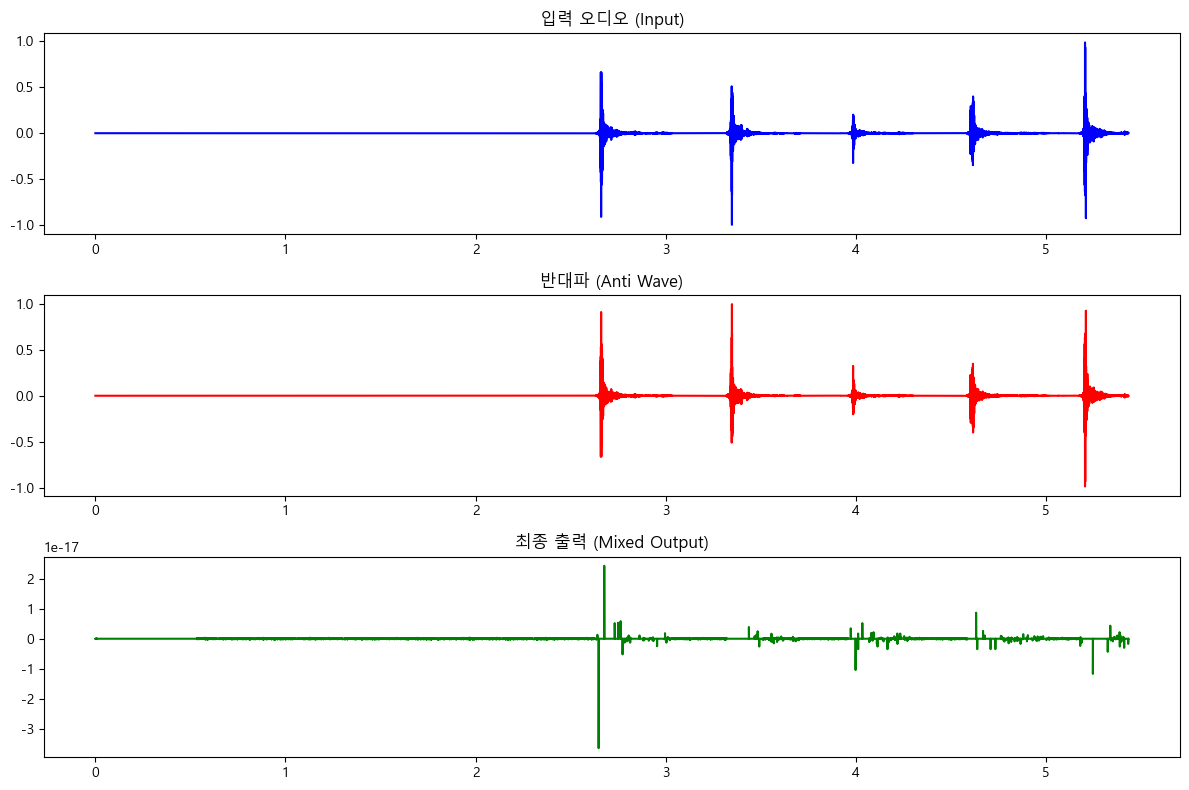

SystemExit: 0

C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py:3587: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [2]:
import numpy as np
import sounddevice as sd
import time
import matplotlib.pyplot as plt
import signal
import sys
import matplotlib

# 한글 폰트 설정
matplotlib.rc('font', family='Malgun Gothic')
matplotlib.rcParams['axes.unicode_minus'] = False

SAMPLE_RATE = 44100  # 샘플레이트 통일
FRAME_SIZE = 512     # 프레임 크기 줄여서 지연 최소화

input_audio_log = []
anti_wave_log = []
mixed_audio_log = []

def generate_anti_wave_from_frame(frame):
    fft = np.fft.rfft(frame)
    magnitude = np.abs(fft)
    phase = np.angle(fft)
    anti_fft = magnitude * np.exp(1j * (phase + np.pi))
    anti_wave = np.fft.irfft(anti_fft)
    anti_wave = anti_wave[:len(frame)]
    anti_wave = np.clip(anti_wave, -1, 1)
    return anti_wave.astype(np.float32)

def audio_callback(indata, outdata, frames, time_info, status):
    global input_audio_log, anti_wave_log, mixed_audio_log

    if status:
        print("Status:", status)

    mono = indata[:, 0]
    anti_wave = generate_anti_wave_from_frame(mono)

    amplify_scale = 1.0
    amplified_anti_wave = np.clip(anti_wave * amplify_scale, -1, 1)

    mixed = np.clip(mono + amplified_anti_wave, -1, 1)

    # mono 출력 (입력 + 반대파 합친 신호)
    outdata[:] = mixed.reshape(-1, 1)

    input_audio_log.append(mono.copy())
    anti_wave_log.append(anti_wave.copy())
    mixed_audio_log.append(mixed.copy())

def handle_exit(sig, frame):
    print("\n📊 기록된 데이터를 시각화합니다...")
    input_audio = np.concatenate(input_audio_log)
    anti_wave = np.concatenate(anti_wave_log)
    mixed_audio = np.concatenate(mixed_audio_log)
    t = np.linspace(0, len(input_audio) / SAMPLE_RATE, len(input_audio))

    plt.figure(figsize=(12, 8))
    plt.subplot(3, 1, 1)
    plt.plot(t, input_audio, label="Original Input", color="blue")
    plt.title("입력 오디오 (Input)")

    plt.subplot(3, 1, 2)
    plt.plot(t, anti_wave, label="Anti Wave", color="red")
    plt.title("반대파 (Anti Wave)")

    plt.subplot(3, 1, 3)
    plt.plot(t, mixed_audio, label="Mixed Output", color="green")
    plt.title("최종 출력 (Mixed Output)")

    plt.tight_layout()
    plt.show()
    sys.exit(0)

signal.signal(signal.SIGINT, handle_exit)

input_device = None
output_device = None

print("🔊 실시간 노이즈 캔슬링 (입력 + 반대파) 출력 중... (Ctrl+C 종료)")
with sd.Stream(device=(input_device, output_device),
               channels=1,         # 모노 출력 (1채널)
               samplerate=SAMPLE_RATE,
               blocksize=FRAME_SIZE,
               callback=audio_callback):
    while True:
        time.sleep(0.1)

[실시간 노이즈 캔슬링 시작 - 소리 출력 없음, Ctrl+C로 종료]

[Ctrl+C 감지됨 - 그래프를 출력합니다]


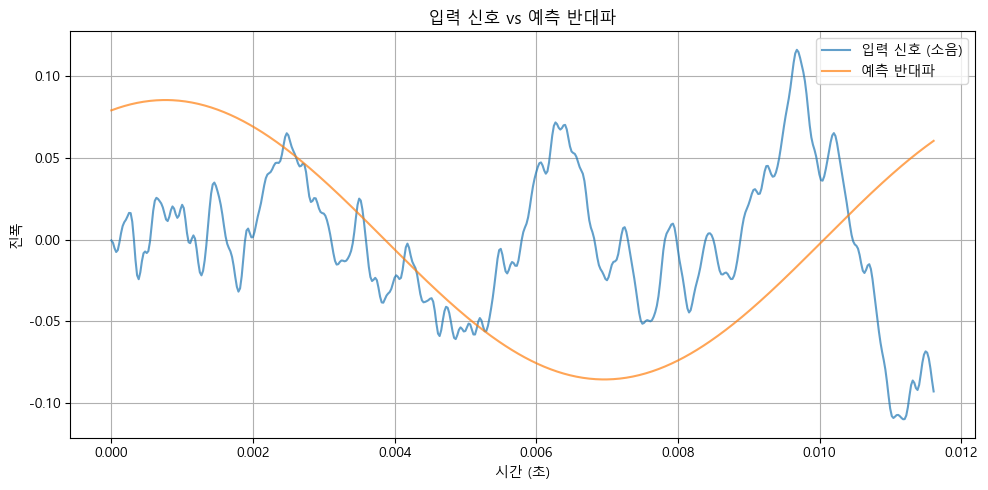

SystemExit: 0

C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py:3587: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [7]:
import numpy as np
import tensorflow as tf
import joblib
import librosa
import sounddevice as sd
import matplotlib.pyplot as plt
import matplotlib
import time
import sys

# 모델 및 스케일러 로드
model = tf.keras.models.load_model("transformer_estimator.h5")
scaler_x = joblib.load("scaler_x.save")
scaler_y = joblib.load("scaler_y.save")

matplotlib.rc('font', family='Malgun Gothic')
matplotlib.rcParams['axes.unicode_minus'] = False

# 오디오 처리 관련 상수
FRAME_LENGTH = 2048
HOP_LENGTH = 512
N_MELS = 64
NUM_FRAMES = 5
RATE = 44100

# 전역 변수
mel_buffer = []
audio_buffer = np.zeros(FRAME_LENGTH, dtype=np.float32)
last_input = None
last_anti_wave = None

# 오디오 콜백 함수
def stream_callback(indata, outdata, frames, time_info, status):
    global mel_buffer, audio_buffer, last_input, last_anti_wave

    mono = indata[:, 0]
    audio_buffer = np.roll(audio_buffer, -HOP_LENGTH)
    audio_buffer[-HOP_LENGTH:] = mono

    mel = librosa.feature.melspectrogram(
        y=audio_buffer, sr=RATE, n_mels=N_MELS,
        n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH)
    mel_db = librosa.power_to_db(mel, ref=np.max).T  # (시간, 주파수)

    for frame in mel_db:
        mel_buffer.append(frame)
        if len(mel_buffer) > NUM_FRAMES:
            mel_buffer.pop(0)
        if len(mel_buffer) == NUM_FRAMES:
            input_seq = np.array(mel_buffer).reshape(1, NUM_FRAMES, N_MELS)
            input_scaled = scaler_x.transform(input_seq.reshape(-1, N_MELS)).reshape(1, NUM_FRAMES, N_MELS)

            pred = model.predict(input_scaled, verbose=0)
            f, a, p = scaler_y.inverse_transform(pred)[0]

            t = np.linspace(0, HOP_LENGTH / RATE, HOP_LENGTH, endpoint=False)
            anti_wave = a * np.sin(2 * np.pi * f * t + p + np.pi)

            outdata[:, 0] = mono.astype(np.float32)

            last_input = mono[:HOP_LENGTH]
            last_anti_wave = anti_wave[:HOP_LENGTH]
            return

    # 충분한 데이터 없으면 무음 출력
    outdata[:, 0] = np.zeros(HOP_LENGTH, dtype=np.float32)

def plot_graph():
    if last_input is not None and last_anti_wave is not None:
        time_axis = np.linspace(0, HOP_LENGTH / RATE, HOP_LENGTH)
        plt.figure(figsize=(10, 5))
        plt.plot(time_axis, last_input, label="입력 신호 (소음)", alpha=0.7)
        plt.plot(time_axis, last_anti_wave, label="예측 반대파", alpha=0.7)
        plt.xlabel("시간 (초)")
        plt.ylabel("진폭")
        plt.title("입력 신호 vs 예측 반대파")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        print("충분한 데이터가 없어 그래프를 표시할 수 없습니다.")

try:
    with sd.Stream(callback=stream_callback, samplerate=RATE, blocksize=HOP_LENGTH, channels=1):
        print("[실시간 노이즈 캔슬링 시작 - 소리 출력 없음, Ctrl+C로 종료]")
        while True:
            time.sleep(0.1)
except KeyboardInterrupt:
    print("\n[Ctrl+C 감지됨 - 그래프를 출력합니다]")
    plot_graph()
    sys.exit(0)

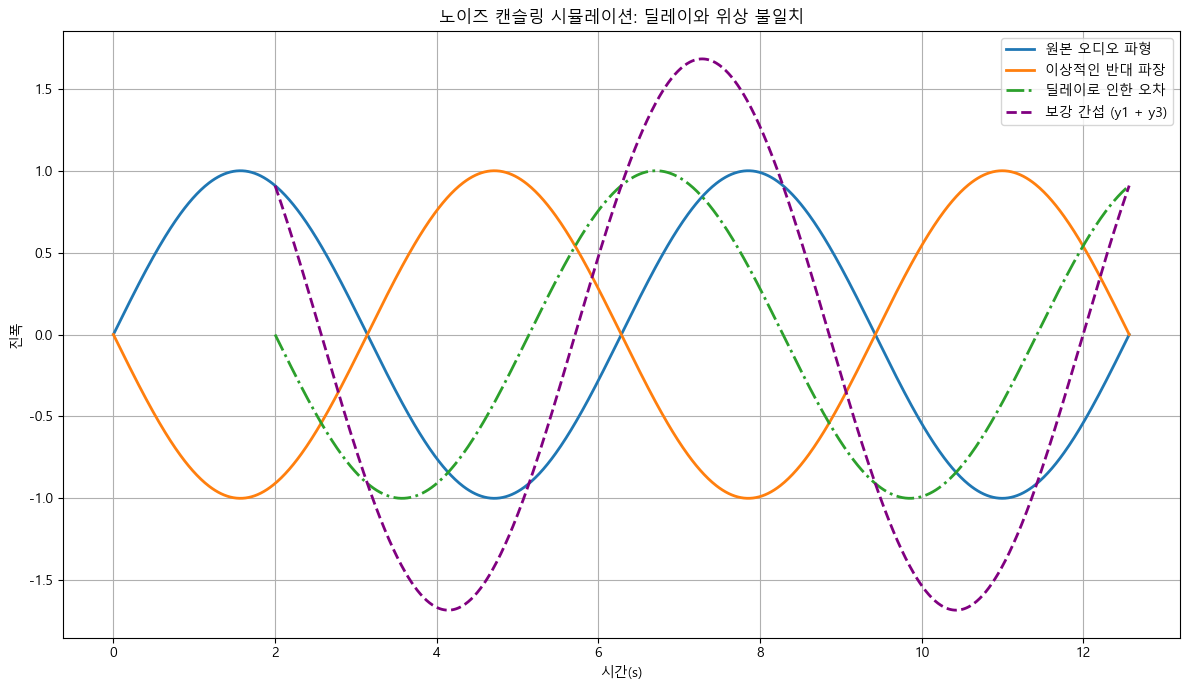

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# 한글 폰트 설정
matplotlib.rc('font', family='Malgun Gothic')
matplotlib.rcParams['axes.unicode_minus'] = False

# Delay and mismatch settings
delay = np.pi
phase_mismatch = 2.0

# Generate x values (전체 구간)
x = np.linspace(0, 4 * np.pi, 1000)

# y1, y2는 원본 신호와 반대파
y1 = np.sin(x)
y2 = np.sin(x - np.pi)

# x >= 0 구간만 골라내기
x_nonneg = x[x >= 0]
y3_full = np.sin(x_nonneg - delay - phase_mismatch)

# y3_full에서 처음으로 0 교차점 찾기
zero_crossings_y3 = np.where(np.diff(np.signbit(y3_full)))[0]
if len(zero_crossings_y3) > 0:
    zero_crossing_y3_index = zero_crossings_y3[0] + 1  # +1은 diff 인덱스 보정
    x3 = x_nonneg[zero_crossing_y3_index:]
    y3 = y3_full[zero_crossing_y3_index:]
else:
    x3 = x_nonneg
    y3 = y3_full

# y1에서 x3에 대응하는 부분을 슬라이스 (x는 1차원 등간격이라 index로 대응 가능)
start_index_in_x = np.searchsorted(x, x3[0])  # x3 첫값에 가장 가까운 x 인덱스
y1_for_sum = y1[start_index_in_x : start_index_in_x + len(y3)]

# 보강 간섭 결과 (y1 + y3)
y_sum = y1_for_sum + y3

# Plotting
plt.figure(figsize=(12, 7))
plt.plot(x, y1, label='원본 오디오 파형', linewidth=2)
plt.plot(x, y2, label='이상적인 반대 파장', linewidth=2)
plt.plot(x3, y3, label='딜레이로 인한 오차', linestyle='-.', linewidth=2)
plt.plot(x3, y_sum, label='보강 간섭 (y1 + y3)', linestyle='--', linewidth=2, color='purple')
plt.title('노이즈 캔슬링 시뮬레이션: 딜레이와 위상 불일치')
plt.xlabel('시간(s)')
plt.ylabel('진폭')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
